<h1 style="font-size:30px"> Mushroom Classification 🍄 POISONOUS OR EDIBLE </h1>

<div style="background-color:#E6F9E6; border:2px solid #66C2A5; padding:20px; border-radius:10px; box-shadow: 0 2px 4px 0 rgba(0,0,0,0.1); font-family:Georgia, serif;">
  <h1 style="color:#4A90E2; text-shadow: 1px 1px #FFF; text-align:center;">Mushroom Binary Classification Using Classifiers (XGBoost and Random Forest)</h1>
  <p style="color:#333; font-size:16px;">
    This notebook applies <span style="color:#1E90FF;"><strong>Classifiers</strong></span> that use two powerful models: <span style="color:#1E90FF;"><strong>XGBoost</strong></span> and <span style="color:#1E90FF;"><strong>Random Forest</strong></span>. The objective is to classify mushroom species as <span style="color:#32CD32;"><strong>edible</strong></span> or <span style="color:#FF4500;"><strong>poisonous</strong></span> based on various features. The following steps were carried out:
  </p>

  <h2 style="color:#66C2A5; text-shadow: 1px 1px 2px rgba(0,0,0,0.1);">1. Data Preparation</h2>
  <p style="color:#333; font-size:16px;">
    We begin by loading the training and test data and getting an overview of their structure, target class, numeric and catagorical features. We then examine the <span style="color:#1E90FF;"><strong>ppscore</strong></span> to get a first glimpse as to which features are important. We then carry out <span style="color:#1E90FF;"><strong>exploratory data analysis</strong></span> and output some plots of the various features separated by their target class (edible or poisonous). There is a mild bias towards poisonous in the overall dataset which we ignore in this analysis but could be corrected by dropping data in a randomised but consistent manner.
  </p>
  <p style="color:#333; font-size:16px;">
    We then clean the data by imputing missing catagorical values with a 'missing' catagory replacing other niose in the data (those lables which appear less than 100 times) with a 'noise' catagory. Missing numeric data is imputed with the mean. We note this imputing of 'missing' catagory has the effect of watering down the data and this is reflected in the ppscores which we discuss. We also discuss the biases present in the missing and noisy data these are mild but one may wish to carry out further feature enginerrring and data engineering to correct for these to prevent data leakage. E.g. for some features the missing catagory (all those data points where that feature was not recorded) has bias towards poisonous, the model may learn this data collection bias this would not generalise well.
  </p>
  <p style="color:#333; font-size:16px;">
    Finally, we encode the catagorical data using <span style="color:#1E90FF;"><strong>one-hot encoding</strong></span> since it does not contain any ordinal relationships.
  </p>
  <h2 style="color:#66C2A5; text-shadow: 1px 1px 2px rgba(0,0,0,0.1);">1. Model Building</h2>
  <p style="color:#333; font-size:16px;">
    We begin with a simple <span style="color:#1E90FF;"><strong>random forest model</strong></span> trained and then validated on 20% of the training data. We find a validation score of MCC 0.9842127758304554 using the mathews correlation coefficient. On the test data we find a public score MCC 0.98450 and private score 0.98441 in the competition. This baseline model hence generalises well given its training accuracy. 
  </p>
  <p style="color:#333; font-size:16px;">
    We then look at another model <span style="color:#1E90FF;"><strong>XGboost</strong></span> also built on decision trees. We again train and then validated on 20% of the training data but this time the model has more hyperparameters and so we perform some <span style="color:#1E90FF;"><strong>hyperparameter tuning</strong></span> using an automated search using <span style="color:#1E90FF;"><strong>Optuna</strong></span>. We only carry out less than 20 trails before selecting our best parameters, this could be extended to 100 trails given more time.
  </p>
  <p style="color:#333; font-size:16px;">
    We then train the model defined by these hyperparameters performing cross validation using <span style="color:#1E90FF;"><strong>stratified K fold</strong></span> with 5 folds and for each fold we get the out of fold MCC validation score and also a probabilty prediction for each target class on the test data from the model trained on that fold. We take a mean of those probabilities and argmax to get a binary prediction. Perfoming k fold cv after data preparation may introduce data leakage (the preparation we carried implicitly used the test data sets from each give fold). a less leaky method would be to do all/most preparation and cleaning within a pipeline in each fold. We do not do this since the cleaning we carried out was informed by the expected distribution of the data gleaned from domain specifid knowledge (e.g. noisy catagories were those with numeric values in catagorical features and those labels which appeared very rarely. e.g. not at all in the real world dataset found at: 'from ucimlrepo import fetch_ucirepo  # needs pip install ucimlrepo').
  </p>
</div>

<a id="1"></a>
# <p style="background-color:#00A36C; font-family:calibri; font-size:130%; color:#F2EBE6; text-align:center; border-radius:15px 50px; padding:10px">1 | Import Libraries</p>

⬆️ [Table of Contents](#contents_tabel)

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import ppscore as pps

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from scipy.stats import mode

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.cluster.hierarchy import linkage, dendrogram

# from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, RocCurveDisplay

# %matplotlib inline

<a id="2"></a>
# <p style="background-color:#00A36C; font-family:calibri; font-size:130%; color:#F2EBE6; text-align:center; border-radius:15px 50px; padding:10px">2 | Read Dataset</p>

⬆️ [Table of Contents](#contents_tabel)

In [3]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

training dataset

train.csv and test.csv are the data sets from the competition which can be found at https://www.kaggle.com/competitions/playground-series-s4e8/data

In [4]:
train_df = pd.read_csv("train.csv", index_col='id')
train_df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


test dataset

In [5]:
test_df = pd.read_csv("test.csv", index_col='id')
test_df.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
3116947,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3116948,3.47,x,t,n,f,s,c,n,4.98,8.51,NaN,NaN,w,NaN,n,t,z,NaN,d,u
3116949,6.17,x,h,y,f,p,NaN,y,6.73,13.70,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


<a id="3"></a>
# <p style="background-color:#00A36C; font-family:calibri; font-size:130%; color:#F2EBE6; text-align:center; border-radius:15px 50px; padding:10px">3 | Dataset Overview</p>

⬆️ [Table of Contents](#contents_tabel)

Null counts and percentages

In [134]:
pd.DataFrame({
    'column': train_df.columns,
    'null-count': train_df.isna().sum().values,
    '% null-count': np.round(train_df.isna().sum().values*100/len(train_df),6)
}).sort_values(by='null-count', ascending=False).reset_index(drop=True)

,column,null-count,% null-count
0,veil-type,2957493,94.884350
1,spore-print-color,2849682,91.425482
2,stem-root,2757023,88.452732
3,veil-color,2740947,87.936970
4,stem-surface,1980861,63.551362
5,gill-spacing,1258435,40.373988
6,cap-surface,671023,21.528227
7,gill-attachment,523936,16.809280
8,ring-type,128880,4.134818
9,gill-color,57,0.001829


We have 20 features with various null counts.

Summary Statistics for Three Numerical Variables

In [135]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cap-diameter,3116941.0,6.309848,4.657931,0.03,3.32,5.75,8.24,80.67
stem-height,3116945.0,6.348333,2.699755,0.00,4.67,5.88,7.41,88.72
stem-width,3116945.0,11.153785,8.095477,0.00,4.97,9.65,15.63,102.90


Summary Statistics for 17 Categorical Variables

In [136]:
train_df.describe(include="object").T

,count,unique,top,freq
class,3116945,2,p,1705396
cap-shape,3116905,74,x,1436026
cap-surface,2445922,83,t,460777
cap-color,3116933,78,n,1359542
does-bruise-or-bleed,3116937,26,f,2569743
gill-attachment,2593009,78,a,646034
gill-spacing,1858510,48,c,1331054
gill-color,3116888,63,w,931538
stem-root,359922,38,b,165801
stem-surface,1136084,60,s,327610


Lots of noise in data shown by the large number of feature labels.

In [137]:
train_df.duplicated().sum()

0

no duplicates

In [138]:
target = 'class'

In [139]:
train_df[target].value_counts()

p    1705396
e    1411549
Name: class, dtype: int64

slight bias towards poisonous mushrooms

In [140]:
features = train_df.drop(target, axis=1).columns.to_list()
features

['cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

In [141]:
categorical_features = train_df[features].select_dtypes(include='object').columns.to_list()
categorical_features

['cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

In [142]:
numerical_features = list(set(features) - set(categorical_features))
numerical_features

['stem-height', 'stem-width', 'cap-diameter']

<div style="background-color:#E6F9E6; border:2px solid #66C2A5; padding:20px; border-radius:10px; box-shadow: 0 2px 4px 0 rgba(0,0,0,0.1); font-family:Georgia, serif;">
  <h2 style="color:#66C2A5; text-shadow: 1px 1px 2px rgba(0,0,0,0.1);">CONCLUSIONS</h2>
  <p style="color:#333; font-size:16px;">
    The training data set consists of 3116945 mushrooms labelled either edible or poisonous (target class). There are 20 features in total, 3 numeric and 17 catagorical. There is missing data in many of the columns some have 50-90% missing.  
  </p>
</div>

<a id="4"></a>
# <p style="background-color:#00A36C; font-family:calibri; font-size:130%; color:#F2EBE6; text-align:center; border-radius:15px 50px; padding:10px">4 | Univariate Exploratory Data Analysis</p>

⬆️ [Table of Contents](#contents_tabel)

Count plots of edible and poisonous class per feature label. Shows the range of value counts for those with more than 100 data points.

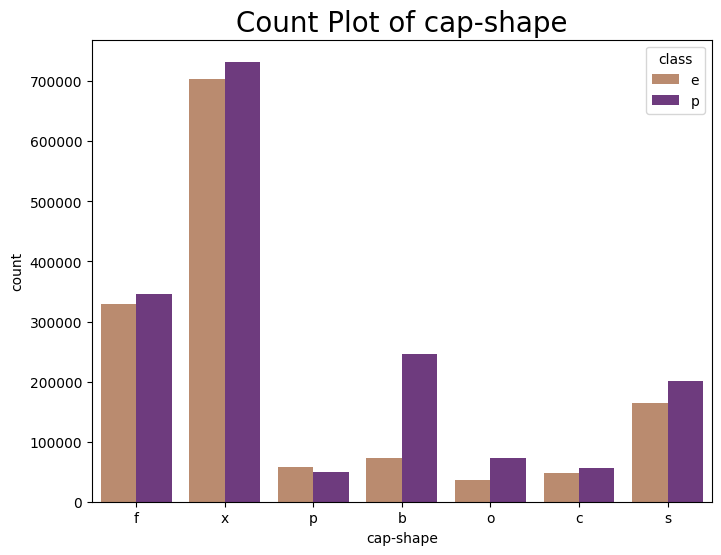

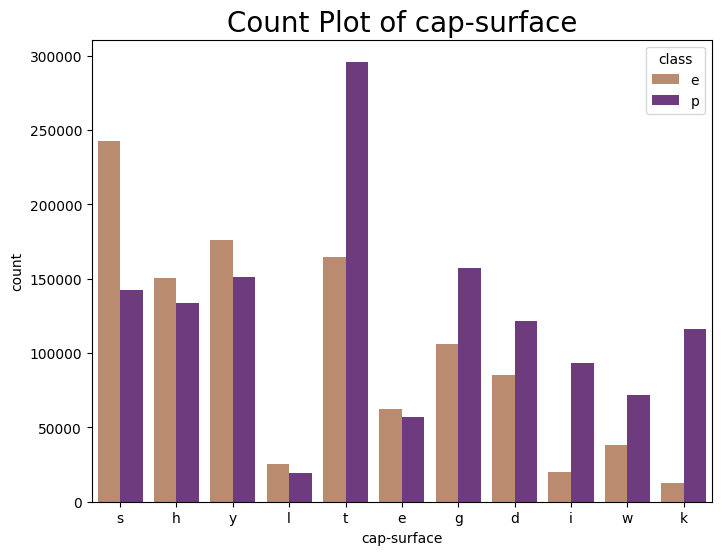

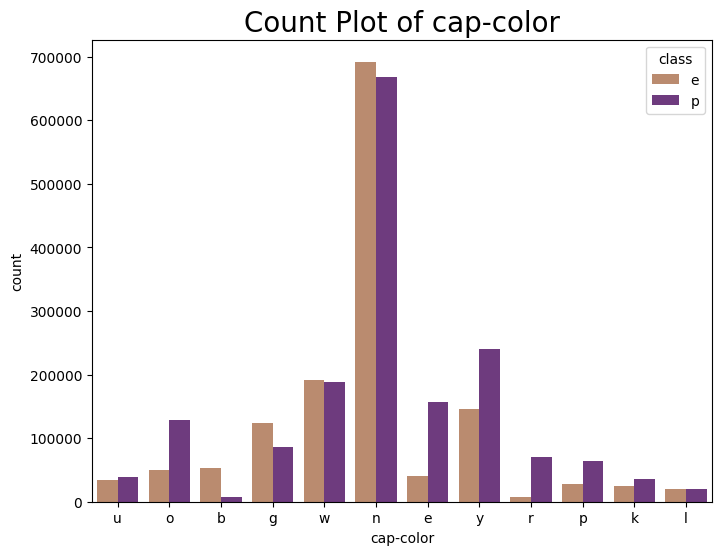

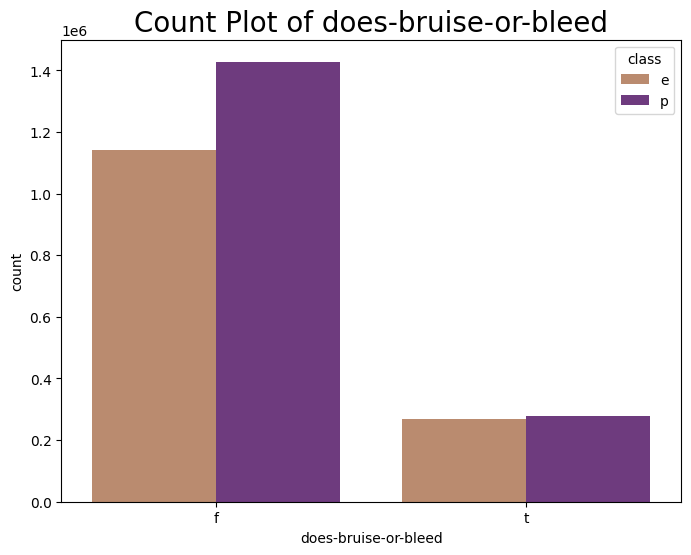

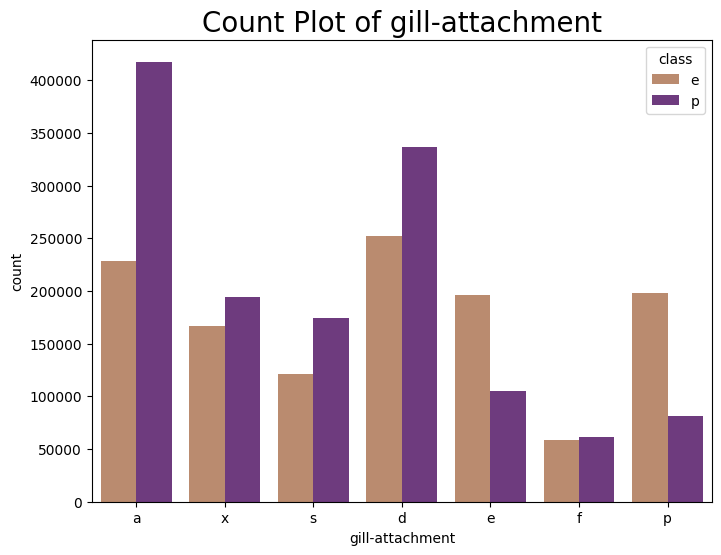

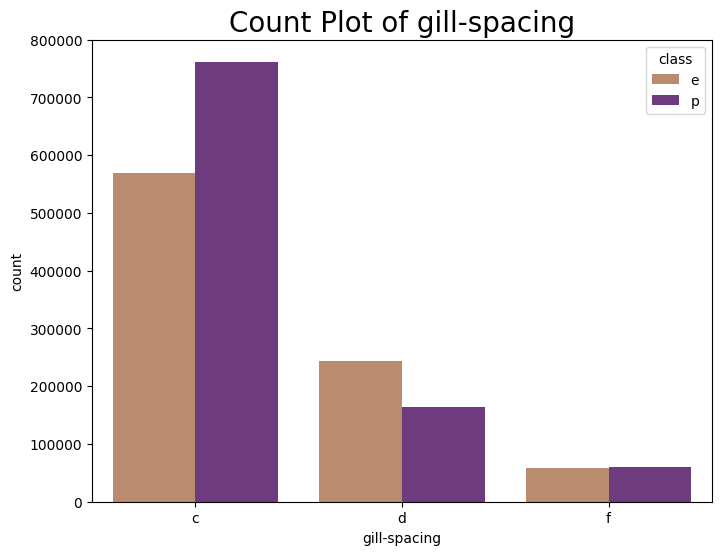

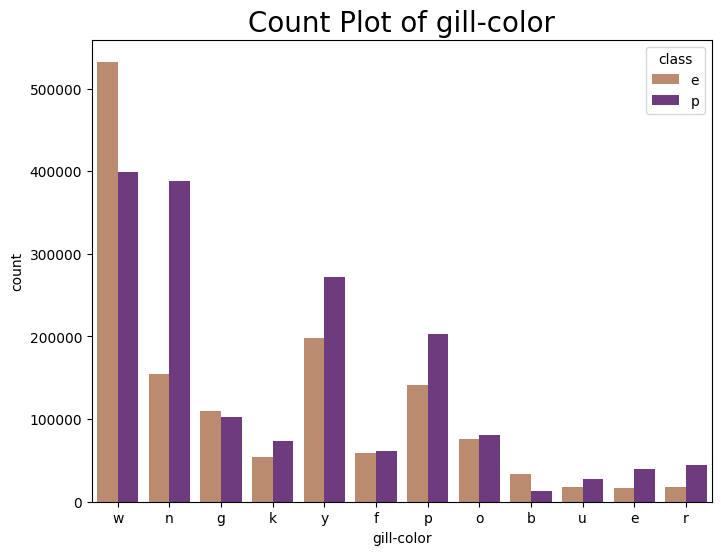

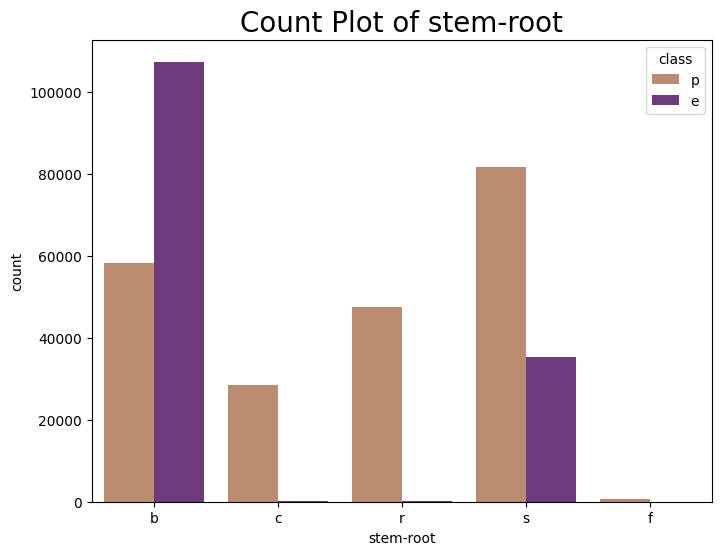

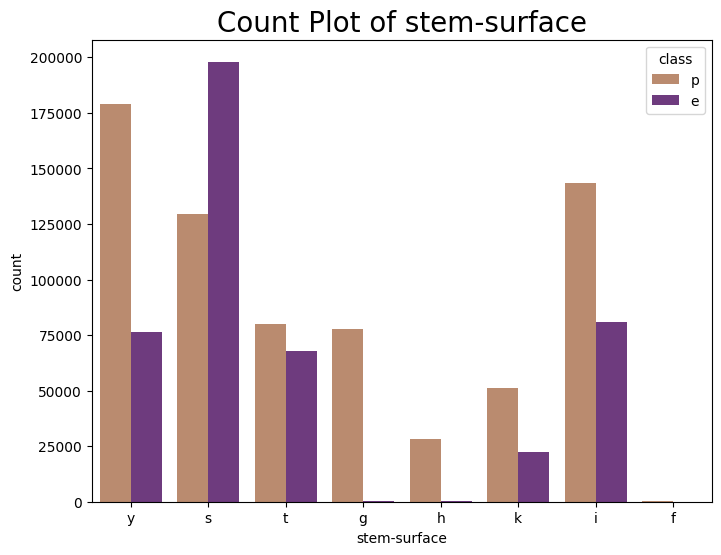

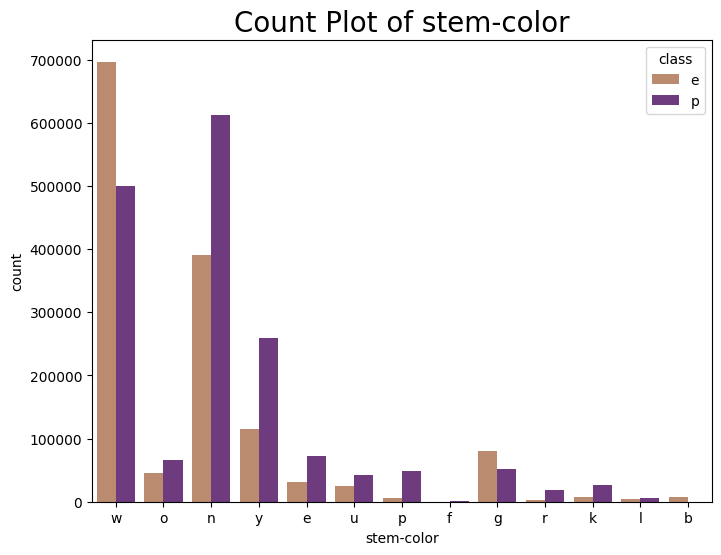

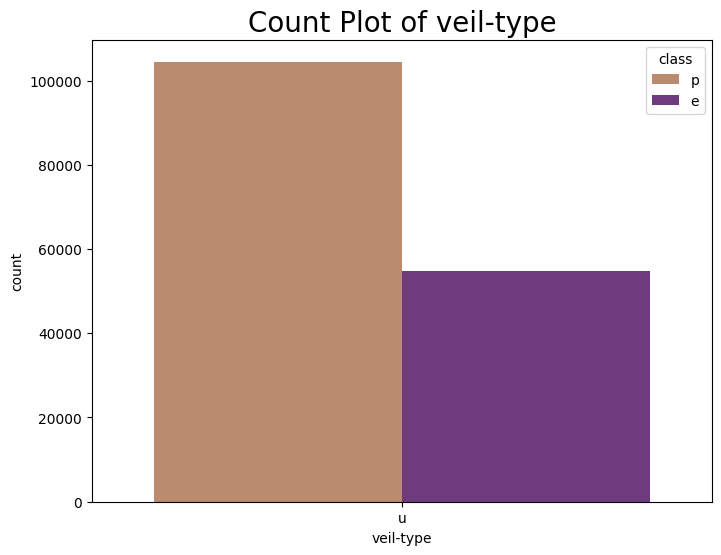

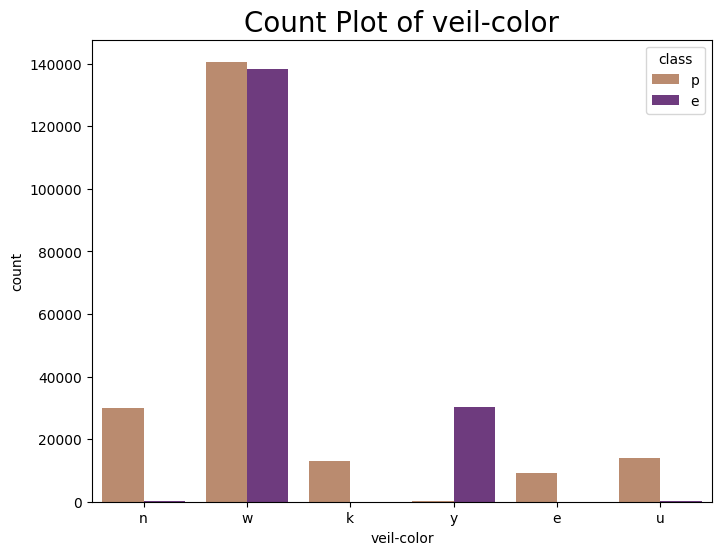

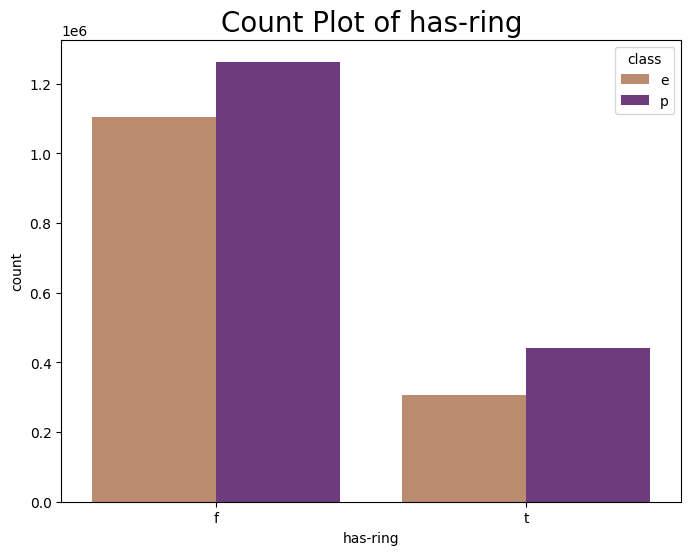

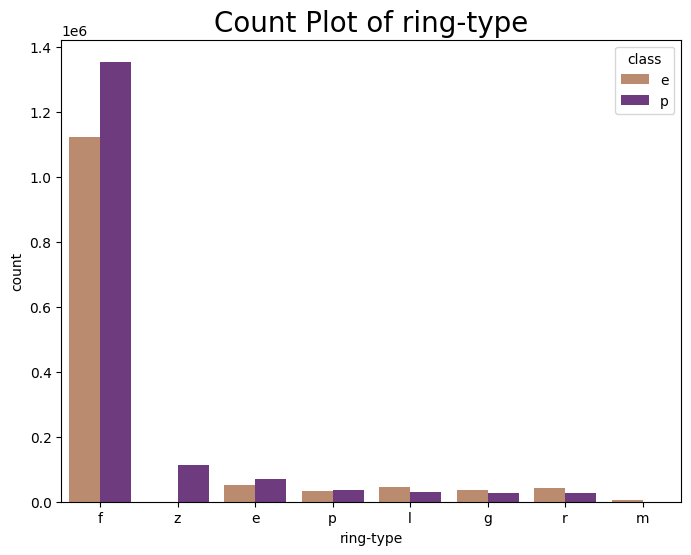

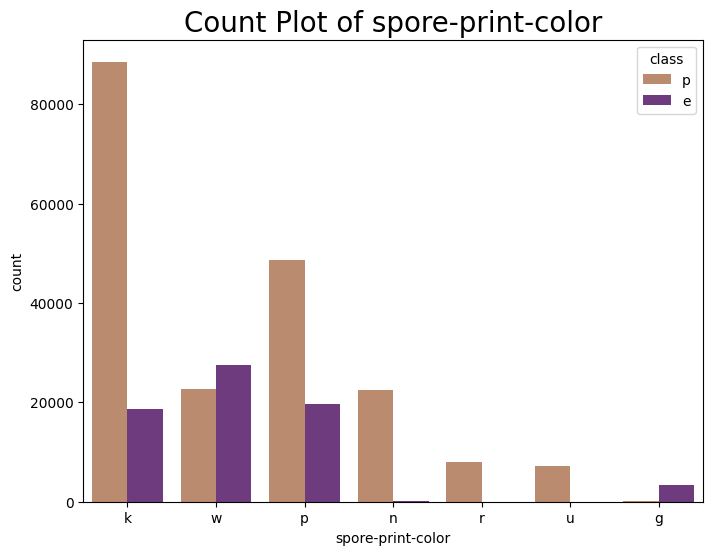

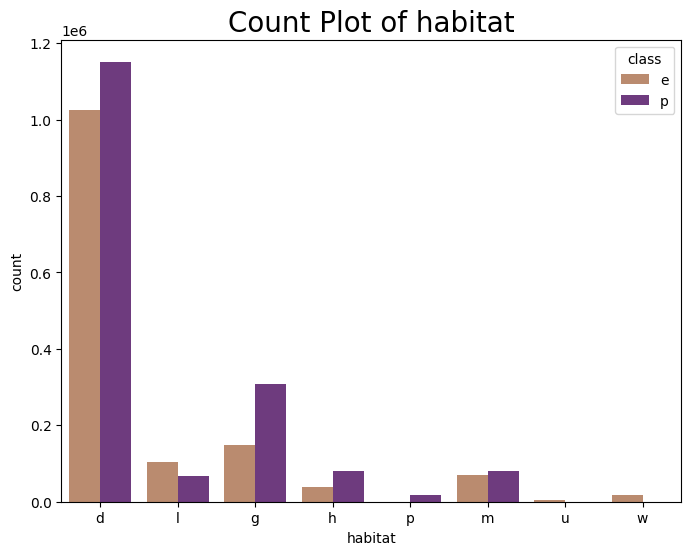

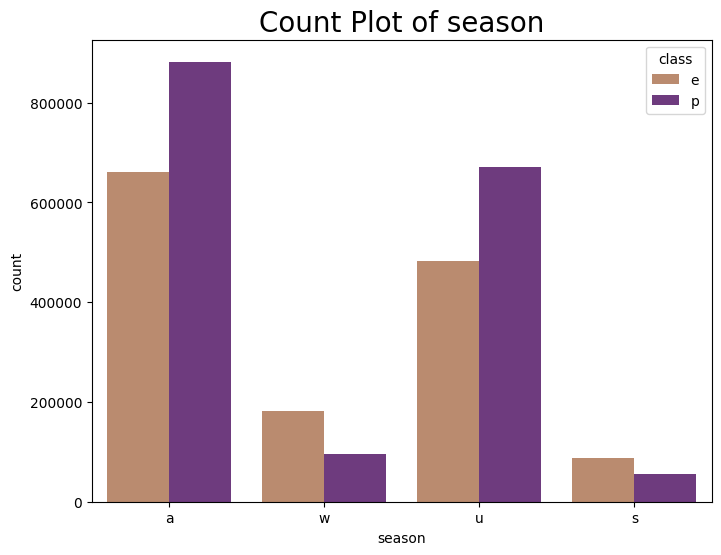

In [143]:
for i, col in enumerate(categorical_features):
    plt.figure(figsize=(8, 6))
    
    count_data = train_df[col].value_counts()
    count_data_rel = count_data[count_data>=100].index
    plot_df = train_df[train_df[col].isin(count_data_rel)]
    
    sns.countplot(x=col, hue=target, data=plot_df)
    
    plt.title(f"Count Plot of {col}", size=20)
    plt.show()

target class separated (poisonous vs edible) histograms of range of values for numerical features

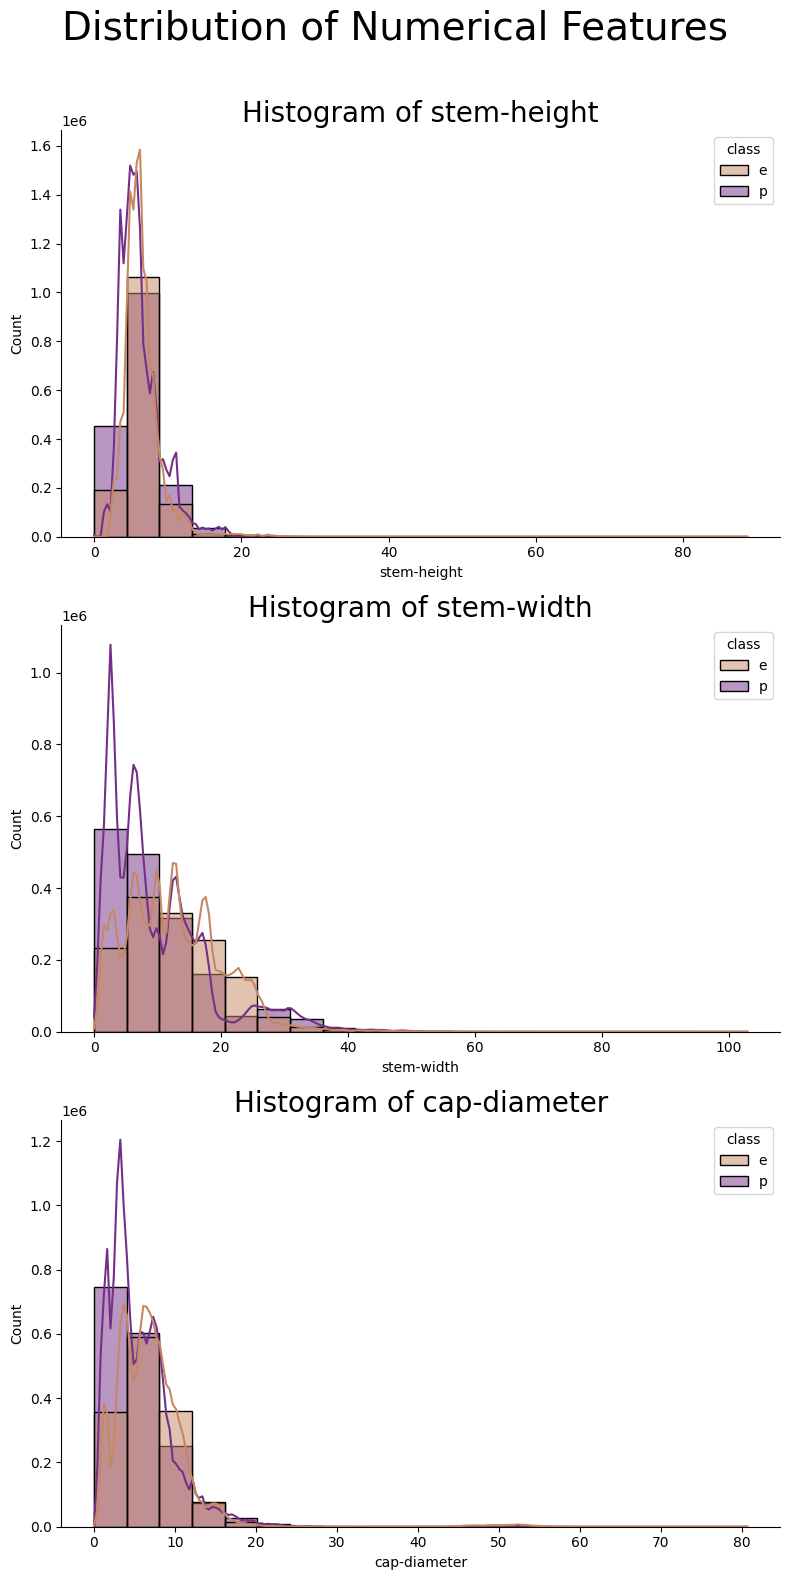

In [144]:
plt.figure(figsize=(8, 15))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 1, i+1)
    sns.histplot(x=col, hue=target, data=train_df, kde=True, bins=20)
    plt.title(f"Histogram of {col}", size=20)
    sns.despine()
plt.tight_layout()
plt.suptitle("Distribution of Numerical Features", y=1.05, size=28)
plt.show()

total counts for target class (edible and poisonous)

[]

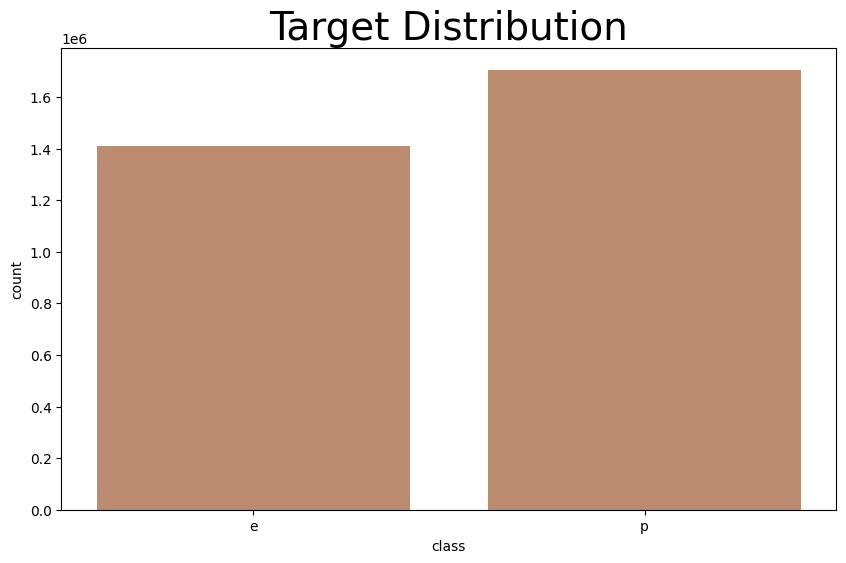

In [145]:
plt.figure(figsize=(10, 6))
sns.countplot(x=target, data=train_df)
plt.title("Target Distribution", size=28)
plt.plot()

slight bias towards poisonous mushrooms

Lets look at feature importance before cleaning. We use ppscore which works for catagorical and numeric data.

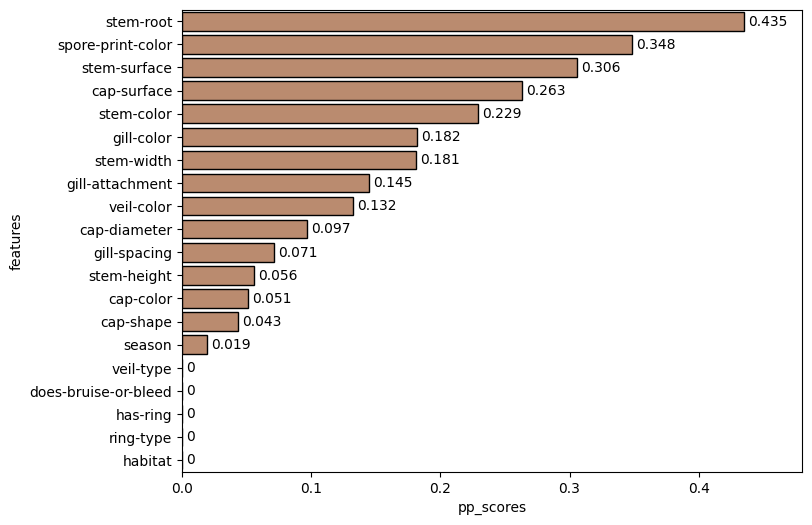

In [146]:


def compute_ppscores(df): 
                     
    pp_scores = []

    for col in df.columns[1:]:
        pp_score = pps.score(df, col, "class")["ppscore"]
        pp_scores.append(pp_score)

    pp_scores_df = pd.DataFrame({
        "features": list(df.columns[1:]),
        "pp_scores": np.round(pp_scores, 3)
    }).sort_values("pp_scores", ascending = False)
    return pp_scores_df

pp_scores_df=compute_ppscores(train_df)

plt.figure(figsize = (8, 6))
ax = sns.barplot(pp_scores_df, x = "pp_scores", y = "features", edgecolor = "#000000")

for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=10)

plt.xlim(0, 0.48)
plt.show()

even columns with lots of artefacts or missing data are 'important'? i.e. cap surface, stem-root. We should not drop these then.

In [147]:
def print_poisonous_percentage(df, col, unique_val):
    n_rows = df[df[col] == unique_val].shape[0]
    print(f"Rows with value of {unique_val}:", n_rows)
    print("Edible %:", round(df[df[col] == unique_val]["class"].value_counts(True).iloc[0], 3))
    print("Posionous %:", round(df[df[col] == unique_val]["class"].value_counts(True).iloc[1], 3))
    print()
    return n_rows

def print_vals(df, col, vals):
    n_rows = 0
    for val in vals:
        n_rows += print_poisonous_percentage(df, col = col, unique_val = val)
    print("Total rows:", n_rows)

In [148]:
print_vals(train_df, col = "stem-root", vals = ["r", "c", "f"])

Rows with value of r: 47803
Edible %: 0.995
Posionous %: 0.005

Rows with value of c: 28592
Edible %: 0.996
Posionous %: 0.004

Rows with value of f: 597
Edible %: 0.988
Posionous %: 0.012

Total rows: 76992


<div style="background-color:#E6F9E6; border:2px solid #66C2A5; padding:20px; border-radius:10px; box-shadow: 0 2px 4px 0 rgba(0,0,0,0.1); font-family:Georgia, serif;">
  <h2 style="color:#66C2A5; text-shadow: 1px 1px 2px rgba(0,0,0,0.1);">CONCLUSIONS</h2>
  <p style="color:#333; font-size:16px;">
    The histograms show that the numeric features have data skewed to lower values with some outliers much greater than their median value. 
  </p>
  <p style="color:#333; font-size:16px;">
    The count plots for the catagorical data are varied come features have only a one commonly seen label others have a handful of labels commonly seen in the data.
  </p>  
  <p style="color:#333; font-size:16px;">
    The entire collected/generated data exhibits a slight bias towards poisonous mushrooms. In a real world example we may fix this bias by dropping some data poitns randomly from th epoisonous class. This would be done to avoid data leakage i.e. the model learning this bias and predict poisonous more often than edible. Such behaviour woul dnot generalise well.
  </p>
  <p style="color:#333; font-size:16px;">
    We also looked at the ppscore. The PPS is an asymmetric, data-type-agnostic score that can detect linear or non-linear relationships between two columns. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). It can be used as an alternative to the correlation (matrix).
    </p>
  <p style="color:#333; font-size:16px;">
    The pppscore showed that for some features such as stem-root with lots of missing data (88% missing) are still important. This is due to the lables 'r,c,f' which strongly correlate to edible mushrooms. So if we see r or c or f for stem-root then we have strong prediction for edible. Unfortunately these labels appear very rarely in the data and for the vast majority we have no stem-root data and no way to predict at all! The feature stem-root is hence in general a weak predictor despite this occasional strong correlation.
  </p>
</div>

<a id="5"></a>
# <p style="background-color:#00A36C; font-family:calibri; font-size:130%; color:#F2EBE6; text-align:center; border-radius:15px 50px; padding:10px">5 | Cleaning Data</p>

⬆️ [Table of Contents](#contents_tabel)

Fill missing values with 'missing' catagory and replace all noise in data (those catagory labels with counts less than 100) with unspecific 'noise' catagory

In [149]:
def cleaner(df):
    for col in categorical_features:
        df[col] = df[col].fillna('missing')
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < 100, col] = "noise"
        df[col] = df[col].astype('category')

    return df

In [150]:
train_df = cleaner(train_df)
test_df = cleaner(test_df)

replace missing values in numeric feautre cap_diameter with the mean

In [151]:
for col in numerical_features:
    train_df[col] = train_df[col].fillna(train_df[col].mean())
    test_df[col] = test_df[col].fillna(train_df[col].mean())

In [152]:
# check for remaining missing values
if (train_df.isnull().sum() == 0).all():
    print("No remaining missing values after filling specified columns.")

if (test_df.isnull().sum() == 0).all():
    print("No remaining missing values after filling specified columns.")

No remaining missing values after filling specified columns.
No remaining missing values after filling specified columns.


check again the ppscores

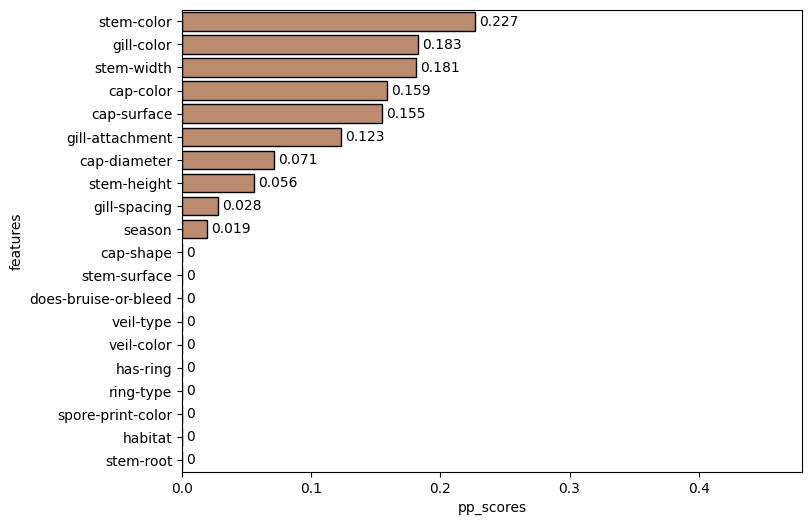

In [153]:
pp_scores_df=compute_ppscores(train_df)

plt.figure(figsize = (8, 6))
ax = sns.barplot(pp_scores_df, x = "pp_scores", y = "features", edgecolor = "#000000")

for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=10)

plt.xlim(0, 0.48)
plt.show()

<div style="background-color:#E6F9E6; border:2px solid #66C2A5; padding:20px; border-radius:10px; box-shadow: 0 2px 4px 0 rgba(0,0,0,0.1); font-family:Georgia, serif;">
  <h2 style="color:#66C2A5; text-shadow: 1px 1px 2px rgba(0,0,0,0.1);">CONCLUSIONS</h2>
    <p style="color:#333; font-size:16px;">
    After dealing with missing data the ppscores are reduced. This is because we have watered down the collected data by filling missing values with 'missing' catagory which contains little information/correlations with target. The data frame and its ppscores now accurately reflect the fact that for some features there was little data collected. These features were strong predictors in the subset of the collected data but poor predictors overall given that it is unlikely that a given mushrrom will have that feature (hence give collectable data) at all.
    </p>
    <p style="color:#333; font-size:16px;">
    This is the correct conclusion IF these missing values are in the themeselves a genuine aspect of those features in the real world i.e. it is practically hard to identify and label these features. This is just a competition though.
    </p>
    <p style="color:#333; font-size:16px;">
    The model should learn this and ignore 'missing' and focus on the powerful catagories/labels (like 'r c f' in stem-root say) and use these in the test data when it can and rely on other features when it can't.
    </p>
</div>

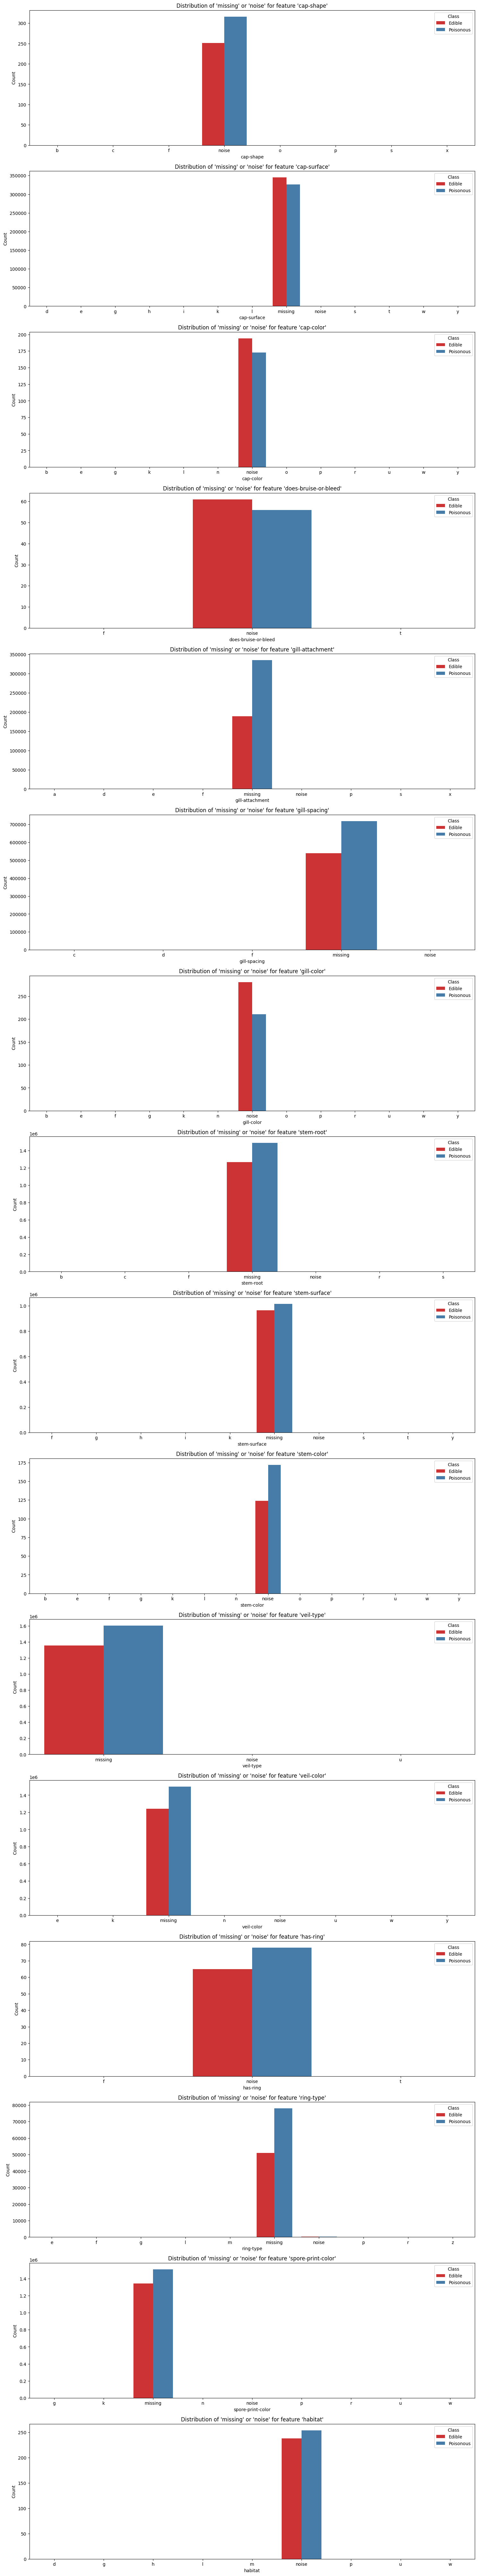

In [154]:
def plot_missing_noise_distribution(df):
    plt.figure(figsize=(15, len(categorical_features) * 5))
    
    for i, col in enumerate(categorical_features, 1):
        missing_noise_df = df[df[col].isin(['missing', 'noise'])]
        
        # check if there are any 'missing' or 'noise' values
        if missing_noise_df.empty:
            continue
        
        plt.subplot(len(categorical_features), 1, i)
        sns.countplot(data=missing_noise_df, x=col, hue='class', palette='Set1')
        plt.title(f"Distribution of 'missing' or 'noise' for feature '{col}'")
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(title='Class', loc='upper right', labels=['Edible', 'Poisonous'])
    
    plt.tight_layout()
    plt.show()

plot_missing_noise_distribution(train_df)

<div style="background-color:#E6F9E6; border:2px solid #66C2A5; padding:20px; border-radius:10px; box-shadow: 0 2px 4px 0 rgba(0,0,0,0.1); font-family:Georgia, serif;">
  <h2 style="color:#66C2A5; text-shadow: 1px 1px 2px rgba(0,0,0,0.1);">CONCLUSIONS</h2>
    <p style="color:#333; font-size:16px;">
    We may wonder about bias present in the data due to how it was collected. The entrie dataset has slight bias towards poisonous.
    </p>
    <p style="color:#333; font-size:16px;">
    Also, for example, feature such as ring-type and gill-attachment has more poisonous mushrooms than edible in the missing data for that feature. The model may then learn this data collection bias and use the ring-type, say, to predict the target. E.g. if the ring-type is 'missing' then predict poisonous, this wil not generalise well and is poor inference. This is known as data leakage.
    </p>
    <p style="color:#333; font-size:16px;">
    The bias is not too strong and we continue with these features in use rather than dropping them.
    </p>
</div>

<a id="9"></a>
# <p style="background-color:#00A36C; font-family:calibri; font-size:130%; color:#F2EBE6; text-align:center; border-radius:15px 50px; padding:10px">9 | Correlation Analysis </p>

⬆️ [Table of Contents](#contents_tabel)

<Figure size 1200x800 with 0 Axes>

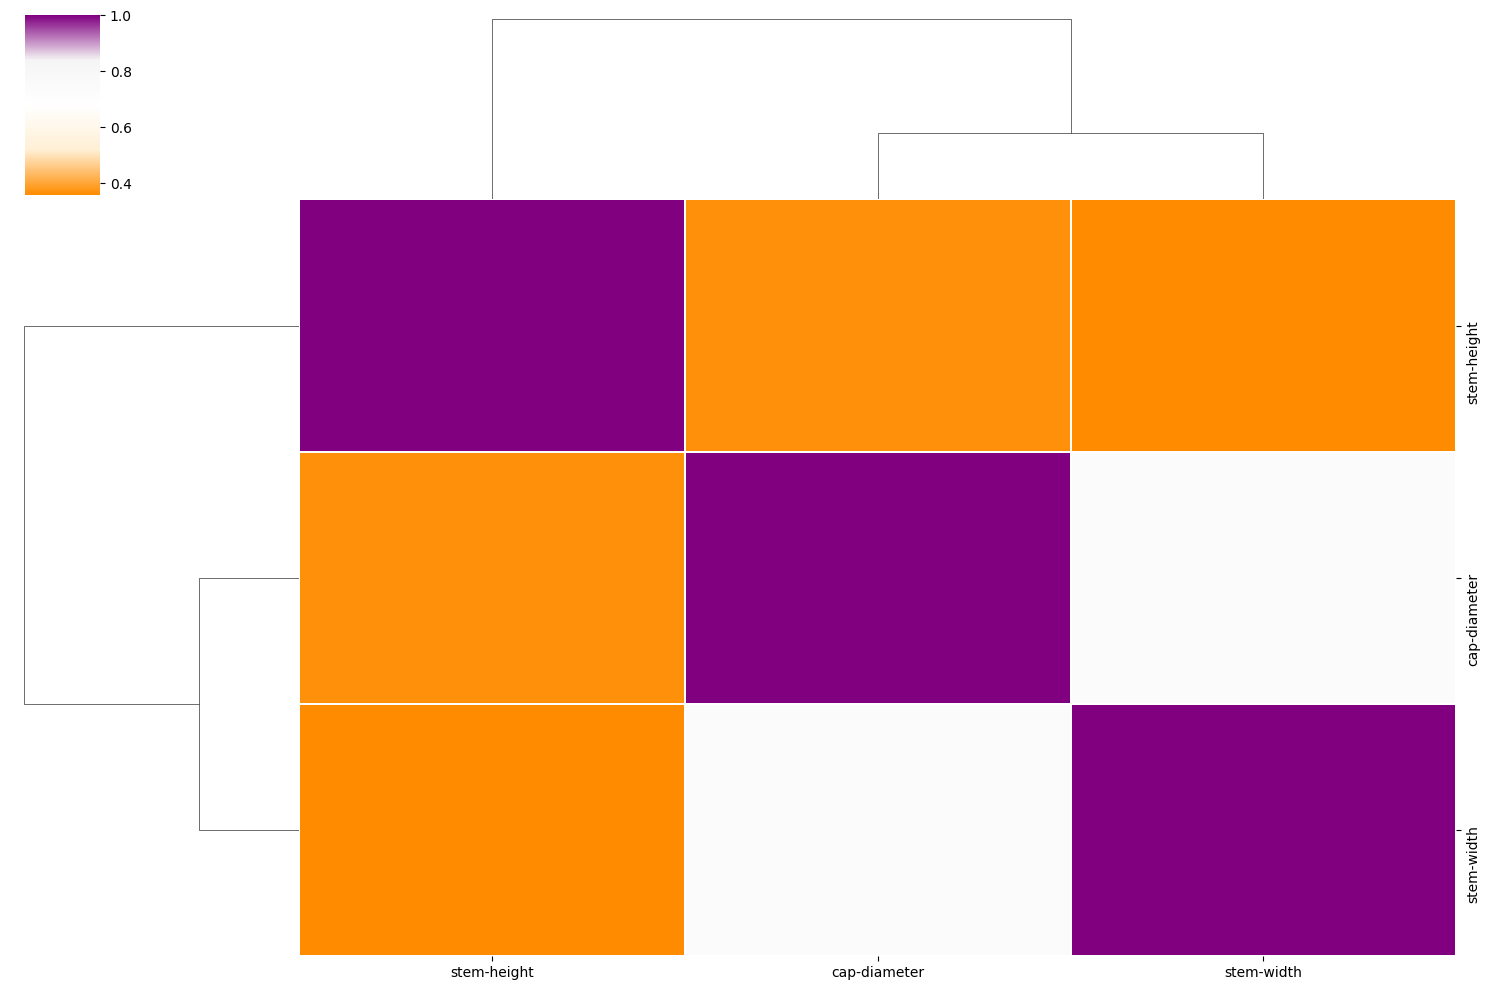

In [155]:
# Define a customized colormap
num_colors = 256
colors = ['#00A36C', '#FFEFD5', 'white', '#F5F5F5', 'purple']
my_cmap = LinearSegmentedColormap.from_list('my_colormap', colors, num_colors)

# Calculation of the Spearman correlation
target = 'class'
train_ordered = pd.concat([train_df.drop(target, axis=1), train_df[target]], axis=1)
corr = train_ordered.corr()

# Perform hierarchical clustering on the correlation matrix
linkage_matrix = linkage(corr, method='average')

# Create a clustered heatmap
plt.figure(figsize=(15, 10), dpi=80)
sns.clustermap(corr, method='average', cmap=my_cmap, linewidths=0.2, figsize=(15, 10), dendrogram_ratio=0.2)

plt.show()

<a id="8"></a>
# <p style="background-color:#00A36C; font-family:calibri; font-size:130%; color:#F2EBE6; text-align:center; border-radius:15px 50px; padding:10px">8 | Pre-processing Cont. Encoding</p>

⬆️ [Table of Contents](#contents_tabel)

In [156]:
X = train_df.drop([target], axis=1)
y = train_df[target]
X.shape,y.shape

((3116945, 20), (3116945,))

In [157]:
# encode catagorical data there are no ordinal relationships so we should use one-hot encoding

def preprocess(df):

    #numeric features are normalised
    scaler = StandardScaler()
    df[numerical_features]=scaler.fit_transform(df[numerical_features])
    
    # catagorical features are binary one-hot encoded
    df=pd.get_dummies(df, columns=categorical_features, drop_first=True)
    one_hot_columns=[col for col in df.columns if col not in numerical_features]

    # convert one-hot encoded columns to integer type
    df[one_hot_columns] = df[one_hot_columns].astype(int)
    return df

X=preprocess(X)
test_df=preprocess(test_df)
label_encoder=LabelEncoder()
y=label_encoder.fit_transform(y)

<a id="11"></a>
# <p style="background-color:#00A36C; font-family:calibri; font-size:130%; color:#F2EBE6; text-align:center; border-radius:15px 50px; padding:10px">11 | Random Forest Model Building </p>

⬆️ [Table of Contents](#contents_tabel)

we use a random forest classifier

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize RandomForestClassifier
rf = RandomForestClassifier(criterion="gini", random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Predict on test data
y_pred = rf.predict(X_test)

# Calculate Matthews correlation coefficient
MCC_score = matthews_corrcoef(y_test, y_pred)
print(f'Matthews Correlation Coefficient: {MCC_score}')


Matthews Correlation Coefficient: 0.9842127758304554


<a id="12"></a>
# <p style="background-color:#00A36C; font-family:calibri; font-size:130%; color:#F2EBE6; text-align:center; border-radius:15px 50px; padding:10px">12 | RF Competition Submission </p>

⬆️ [Table of Contents](#contents_tabel)

In [159]:

# Target prediction for test.csv samples using relavant features
test_predictions=rf.predict(test_df)

# Convert predictions to 'p' and 'e' labels
test_predictions_df=pd.DataFrame({'class' : test_predictions}, index=testdata.index)
test_predictions_df['class'] = np.where(test_predictions == 1, 'p', 'e')

# Save the updated submission file
test_predictions_df['class'].to_csv('submissionRF.csv')

predictions=pd.read_csv('submissionRF.csv')
print("submission file created")

submission file created


In [160]:
print(predictions.head())
print(len(predictions))
print(predictions['class'].value_counts())

        id class
0  3116945     e
1  3116946     p
2  3116947     p
3  3116948     p
4  3116949     e
2077964
p    1133333
e     944631
Name: class, dtype: int64


In [161]:
sample=pd.read_csv('sample_submission.csv')
print(sample.head())
print(len(sample))

        id class
0  3116945     e
1  3116946     e
2  3116947     e
3  3116948     e
4  3116949     e
2077964


<a id="12"></a>
# <p style="background-color:#00A36C; font-family:calibri; font-size:130%; color:#F2EBE6; text-align:center; border-radius:15px 50px; padding:10px">12 | Multi-model Builder </p>

⬆️ [Table of Contents](#contents_tabel)

We define a function which trains and validates a given model on the data. Validation is don ewith f1 score and mathews correlation. We also show a confusion matrix comparing the model predictions with the true values for the validation set. We cross validate @ 20% of the date shuffling this data set before hand.

In [162]:
def model_train_validate(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)
    
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")
    
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

baseline models with no hyperparameter tuning

XGBoost

    Model: XGBClassifier
F1 Score : 0.991582
MCC Score: 0.981441


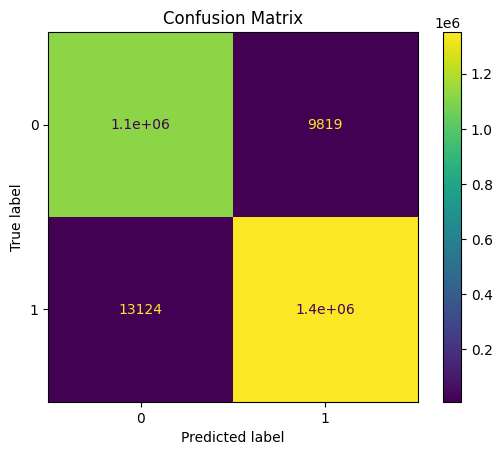

In [163]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_train_validate(xgb_clf, X, y)

    Model: CatBoostClassifier
F1 Score : 0.992142
MCC Score: 0.982674


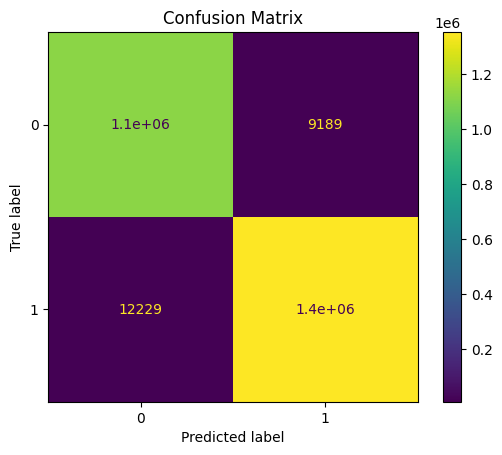

In [166]:
cat_clf = CatBoostClassifier(
    verbose=False,
    allow_writing_files=False,
)

model_train_validate(cat_clf, X, y)

    Model: LGBMClassifier
F1 Score : 0.989472
MCC Score: 0.976825


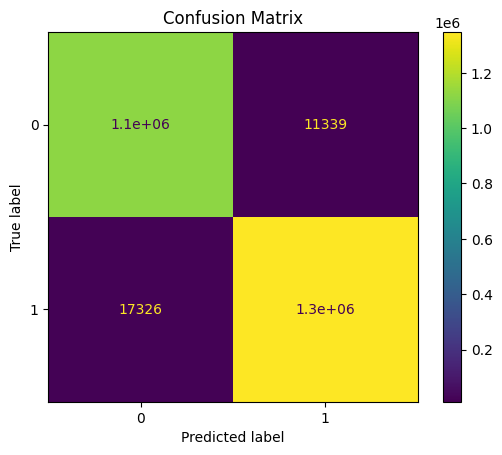

In [168]:
lgb_clf = LGBMClassifier(verbosity=-1)

model_train_validate(lgb_clf, X, y)

<a id="12"></a>
# <p style="background-color:#00A36C; font-family:calibri; font-size:130%; color:#F2EBE6; text-align:center; border-radius:15px 50px; padding:10px">12 | Hyperparameter Tuning </p>

⬆️ [Table of Contents](#contents_tabel)

tune using optuna

focus on the XGBoost algorithm

In [169]:
import optuna
from optuna.samplers import TPESampler

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, shuffle=True, stratify=y, random_state=42)

In [174]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 2000, 3000),
#         "eta": trial.suggest_float("eta", 1e-3, 1e-2),
#         "gamma": trial.suggest_float("gamma", 0, 5.0),
#         "max_depth": trial.suggest_int("max_depth", 2, 32),
#         "min_child_weight": trial.suggest_int("min_child_weight", 40, 100),
#         "subsample": trial.suggest_float("subsample", 0.1, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
#         "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
#         "max_leaves": trial.suggest_int("max_leaves", 16, 84)
#     }
#     params['device'] = 'cuda'
#     params['tree_method'] = 'hist'
    
#     model = XGBClassifier(**params)
#     model.fit(X_train, y_train)
    
#     y_pred = model.predict(X_test)
#     return matthews_corrcoef(y_test, y_pred)


# study_name = "xgb"
# storage = "sqlite:///xgb.db"

# study = optuna.create_study(storage=storage,
#                             study_name=study_name,
#                             direction="maximize",
#                              sampler=TPESampler(),
#                             load_if_exists=True)

# study.optimize(objective, n_trials=100)

# print(study.best_params)

In [175]:
good_params={'n_estimators': 2208, 'eta': 0.00671566488592373, 'gamma': 3.596460399196682, 'max_depth': 26, 'min_child_weight': 54, 
             'subsample': 0.9770213878254449, 'colsample_bytree': 0.389779780183577, 'grow_policy': 'depthwise', 'max_leaves': 84}

<a id="12"></a>
# <p style="background-color:#00A36C; font-family:calibri; font-size:130%; color:#F2EBE6; text-align:center; border-radius:15px 50px; padding:10px">12 | Training Best XGB Model </p>

⬆️ [Table of Contents](#contents_tabel)

Define model trainer which uses K fold cross validation. 

In [176]:
def model_trainer(model, X, y, n_splits=5, random_state=42):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    oof_probs, oof_mccs = [], []
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df))
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
    print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

probabilities for each class

In [177]:
oof_probs = {}
oof_probs['xgb'], _ = model_trainer(XGBClassifier(**good_params), X, y, random_state=42)


Training XGBClassifier
--- Fold 1 MCC Score: 0.983088
--- Fold 2 MCC Score: 0.983157
--- Fold 3 MCC Score: 0.983001
--- Fold 4 MCC Score: 0.982789
--- Fold 5 MCC Score: 0.983011

---> Mean MCC Score: 0.983009 ± 0.000124




extract predictions by taking mean probability over each fold and the choosin the class with higher probability

In [178]:
oof_preds = {}
for model in oof_probs.keys():
    oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis=0), axis=1)

for multiple models we take the mode i.e. most common prediction of the model ensemble. We coul dhave also take the average of the probabilities and then extracted a prediction. 

In [183]:
sub = pd.read_csv("sample_submission.csv")
preds = [pred for model, pred in oof_preds.items()]
md = mode(preds, axis=0)[0] if len(preds)>1 else preds[0]
sub[target] = label_encoder.inverse_transform(md)
sub.to_csv("submissionXGBtuna.csv", index=False)